In [1]:
import random
from typing import Generator

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
random.seed(10)

# Informações sobre o dataset

In [19]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


# Quantidade de dados por classe

In [20]:
df.quality.value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

## Mapeamento para classe binárias:

- 0: menor ou igual a 5
- 1: maior que 5

In [35]:
y = df.quality.apply(lambda quality: 0 if quality <= 6 else 1)

In [36]:
y.value_counts()

0    3838
1    1060
Name: quality, dtype: int64

# Distribuição dos atributos

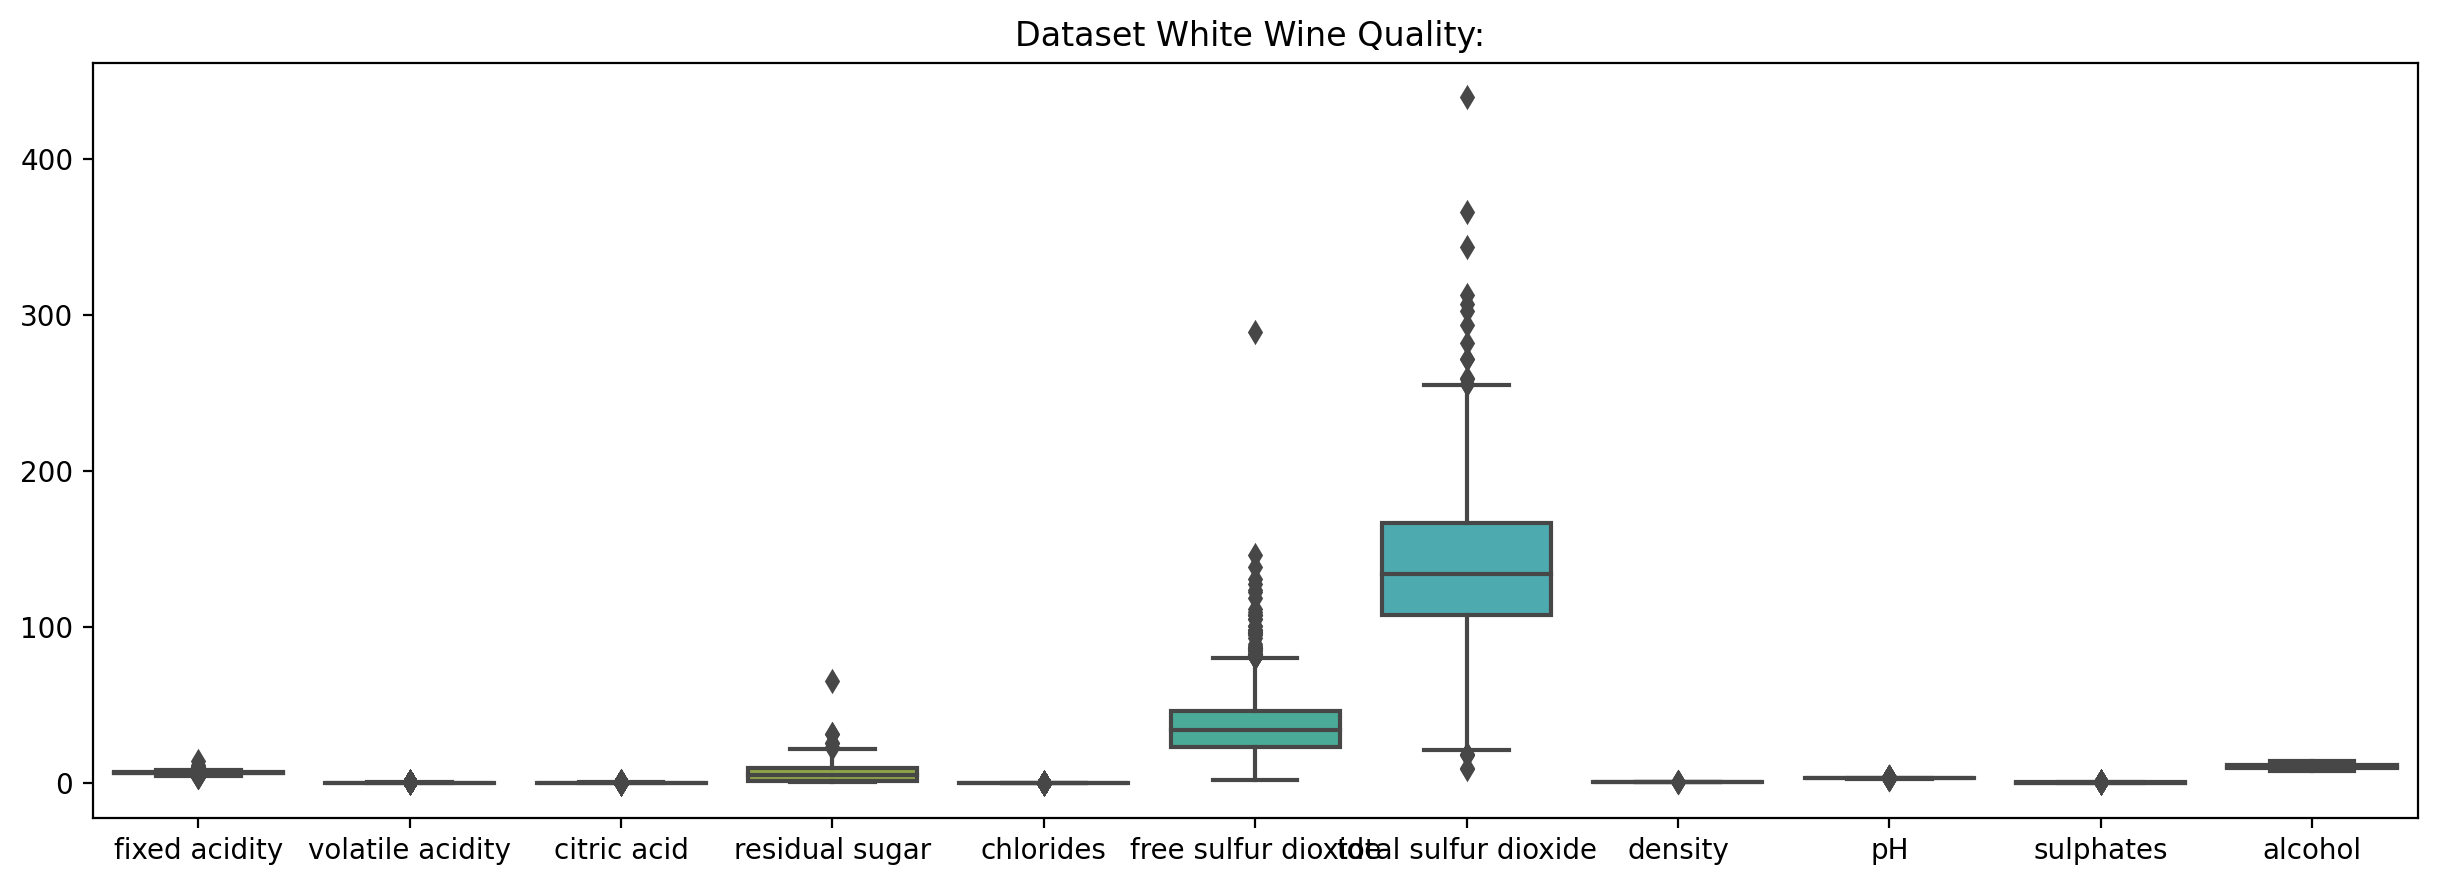

In [37]:
plt.figure(figsize=(15, 5), dpi=200)
sns.boxplot(df.iloc[:,:-1])
plt.title("Dataset White Wine Quality: ")
plt.savefig('../images/wine_quality_attributes.jpg', bbox_inches='tight');

## Normalização necessária devido a grande variação entre as escalas dos atributos

In [12]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(df.iloc[:,:-1])
X =  min_max_scaler.transform(df.iloc[:,:-1])

# Estrutura de dados

Lista de tuplas(atributos, classe)

In [18]:
df_values = list(zip(X.tolist(), y))

In [19]:
df_values[:3]

[([0.24778761061946908,
   0.39726027397260266,
   0.0,
   0.0684931506849315,
   0.10684474123539231,
   0.14084507042253522,
   0.0989399293286219,
   0.567547723935391,
   0.606299212598425,
   0.13772455089820365,
   0.15384615384615397],
  0),
 ([0.2831858407079646,
   0.5205479452054794,
   0.0,
   0.11643835616438356,
   0.14357262103505844,
   0.33802816901408456,
   0.215547703180212,
   0.4941262848751933,
   0.3622047244094486,
   0.2095808383233533,
   0.2153846153846155],
  0),
 ([0.2831858407079646,
   0.4383561643835616,
   0.04,
   0.0958904109589041,
   0.1335559265442404,
   0.19718309859154928,
   0.16961130742049468,
   0.5088105726872243,
   0.4094488188976375,
   0.1916167664670659,
   0.2153846153846155],
  0)]

In [24]:
with open("test_values.txt", "w") as file:
    file.write("%s\n" % df_values)

In [11]:
K = 4

In [34]:
def generate_folds(values: list[tuple[list[int], int]], K: int) -> list[list[int]]:
    indexes_with_false_label = [index for index, value in enumerate(values) if value[1] == 0]
    indexes_with_true_label = [index for index, value in enumerate(values) if value[1] == 1]
    random.shuffle(indexes_with_false_label)
    random.shuffle(indexes_with_true_label)
    folds = [[] for _ in range(K)]
    for _ in range(int(len(values) / K)):
        try:
            for fold in folds:
                index_false_label = indexes_with_false_label.pop(0)
                index_true_label = indexes_with_true_label.pop(0)
                fold.extend([index_false_label, index_true_label])
        except IndexError:
            break

    return set([tuple(fold) for fold in folds])

In [37]:
def test_totally_disjointed_folds(folds: list[list[int]]) -> None:
    joined_folds = []
    for fold in folds:
        joined_folds.extend(fold)

    assert len(joined_folds) == len(set(joined_folds))

In [45]:
def test_balanced_folds(folds: list[list[int]], values: list[tuple[list[int], int]]) -> None:
    for fold in folds:
        assert np.asarray([row[1] for index, row
                           in enumerate(values)
                           if index in fold]
                          ).mean() \
               == 0.5

In [15]:
def generate_splits(K: int) -> Generator[tuple[tuple[int], int], None, None]:
    splits = []
    for index_fold_test in range(K):
        folds_for_training = []
        splits.append((folds_for_training, index_fold_test))
        for index_fold_train in range(K):
            if index_fold_train != index_fold_test:
                folds_for_training.append(index_fold_train)

    splits = ((tuple(folds_for_training), fold_for_test) for folds_for_training, fold_for_test in splits)
    return splits

In [35]:
K = 10
folds = generate_folds(df_values, K)

In [44]:
list(folds)[0]

(1533,
 271,
 1400,
 1023,
 1511,
 826,
 580,
 1038,
 1492,
 453,
 76,
 806,
 400,
 1584,
 45,
 715,
 80,
 803,
 1579,
 1072,
 1189,
 603,
 1085,
 113,
 110,
 544,
 994,
 357,
 934,
 1335,
 893,
 1160,
 1370,
 1435,
 735,
 1175,
 1393,
 494,
 431,
 588,
 750,
 614,
 928,
 331,
 1225,
 91,
 32,
 1134,
 939,
 1549,
 1027,
 1489,
 1373,
 1278,
 1353,
 697,
 295,
 270,
 540,
 1578,
 757,
 1015,
 178,
 1506,
 724,
 1079,
 1263,
 405,
 120,
 867,
 1176,
 953,
 1589,
 1014,
 646,
 328,
 446,
 868,
 433,
 1011,
 1331,
 957,
 1260,
 1249,
 1069,
 1081,
 1124,
 943,
 930,
 484,
 728,
 283,
 175,
 1206,
 661,
 1529,
 581,
 589,
 299,
 609,
 879,
 1317,
 615,
 401,
 1232,
 33,
 719,
 1279,
 823,
 558,
 256,
 1005,
 38,
 1136,
 819,
 231,
 880,
 598,
 50,
 1223,
 1471,
 1093,
 1348,
 516,
 781,
 1234,
 1465,
 1588,
 545,
 745,
 834,
 379,
 1262,
 330,
 53,
 509,
 931,
 1466,
 333,
 1008,
 1523,
 1208,
 587,
 1434,
 107,
 1321,
 373,
 1218)

In [46]:
test_balanced_folds(folds, values)

In [18]:
list(splits)

[((1, 2, 3, 4, 5, 6, 7, 8, 9), 0),
 ((0, 2, 3, 4, 5, 6, 7, 8, 9), 1),
 ((0, 1, 3, 4, 5, 6, 7, 8, 9), 2),
 ((0, 1, 2, 4, 5, 6, 7, 8, 9), 3),
 ((0, 1, 2, 3, 5, 6, 7, 8, 9), 4),
 ((0, 1, 2, 3, 4, 6, 7, 8, 9), 5),
 ((0, 1, 2, 3, 4, 5, 7, 8, 9), 6),
 ((0, 1, 2, 3, 4, 5, 6, 8, 9), 7),
 ((0, 1, 2, 3, 4, 5, 6, 7, 9), 8),
 ((0, 1, 2, 3, 4, 5, 6, 7, 8), 9)]